In [1]:
#################################################################################################
# Import necessary libraries
#################################################################################################
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from time import time
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

In [2]:
#################################################################################################
# Import data
#################################################################################################
Data_DF = pd.read_excel("Concrete_Compressive_Strength_Dataset.xlsx")

In [3]:
#################################################################################################
# Prepare engineered features
#################################################################################################
Data_DF['W/B Ratio'] = Data_DF['Water']/(Data_DF['Cement'] + Data_DF['Blast Furnace Slag'] + Data_DF['Fly Ash'])

Data_DF['BFS/W Ratio'] = Data_DF['Blast Furnace Slag']/Data_DF['Water']

Data_DF['FA/W Ratio'] = Data_DF['Fly Ash']/Data_DF['Water']

Data_DF['CA/B Ratio'] = Data_DF['Coarse Aggregate']/(Data_DF['Cement'] + Data_DF['Blast Furnace Slag'] + Data_DF['Fly Ash'])

Data_DF['CA/FA Ratio'] = Data_DF['Coarse Aggregate']/Data_DF['Fine Aggregate']

In [4]:
df1 = Data_DF.describe()
df1.to_excel("Descriptive Statistics.xlsx")

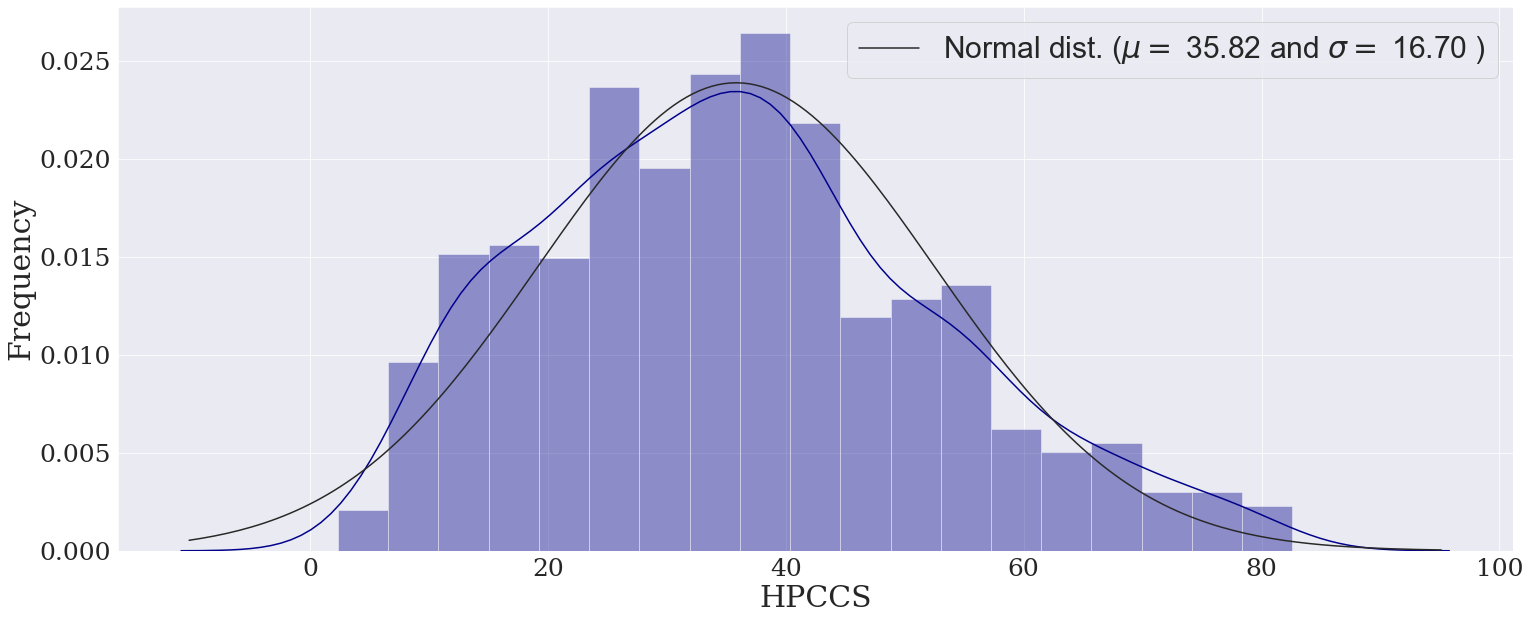

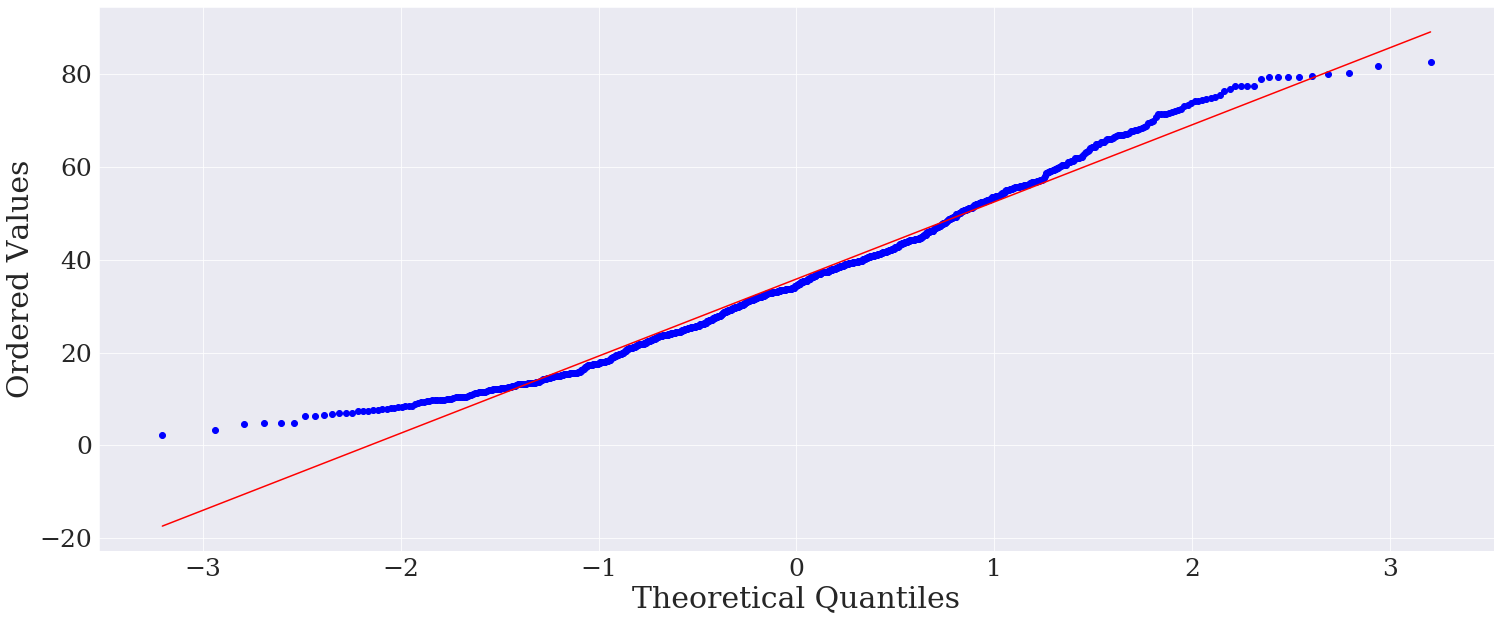

In [5]:
fig = plt.figure(figsize=(25,10),dpi=72)
sns.distplot(Data_DF['Compressive Strength'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(Data_DF['Compressive Strength'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('HPCCS', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('HPCC Distribution 1.pdf')

fig = plt.figure(figsize=(25,10),dpi=72)
res = stats.probplot(Data_DF['Compressive Strength'], plot=plt)
plt.xlabel('Theoretical Quantiles', fontsize=30, fontname='Serif')
plt.ylabel('Ordered Values', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.show
plt.savefig('HPCC Distribution 2.pdf')

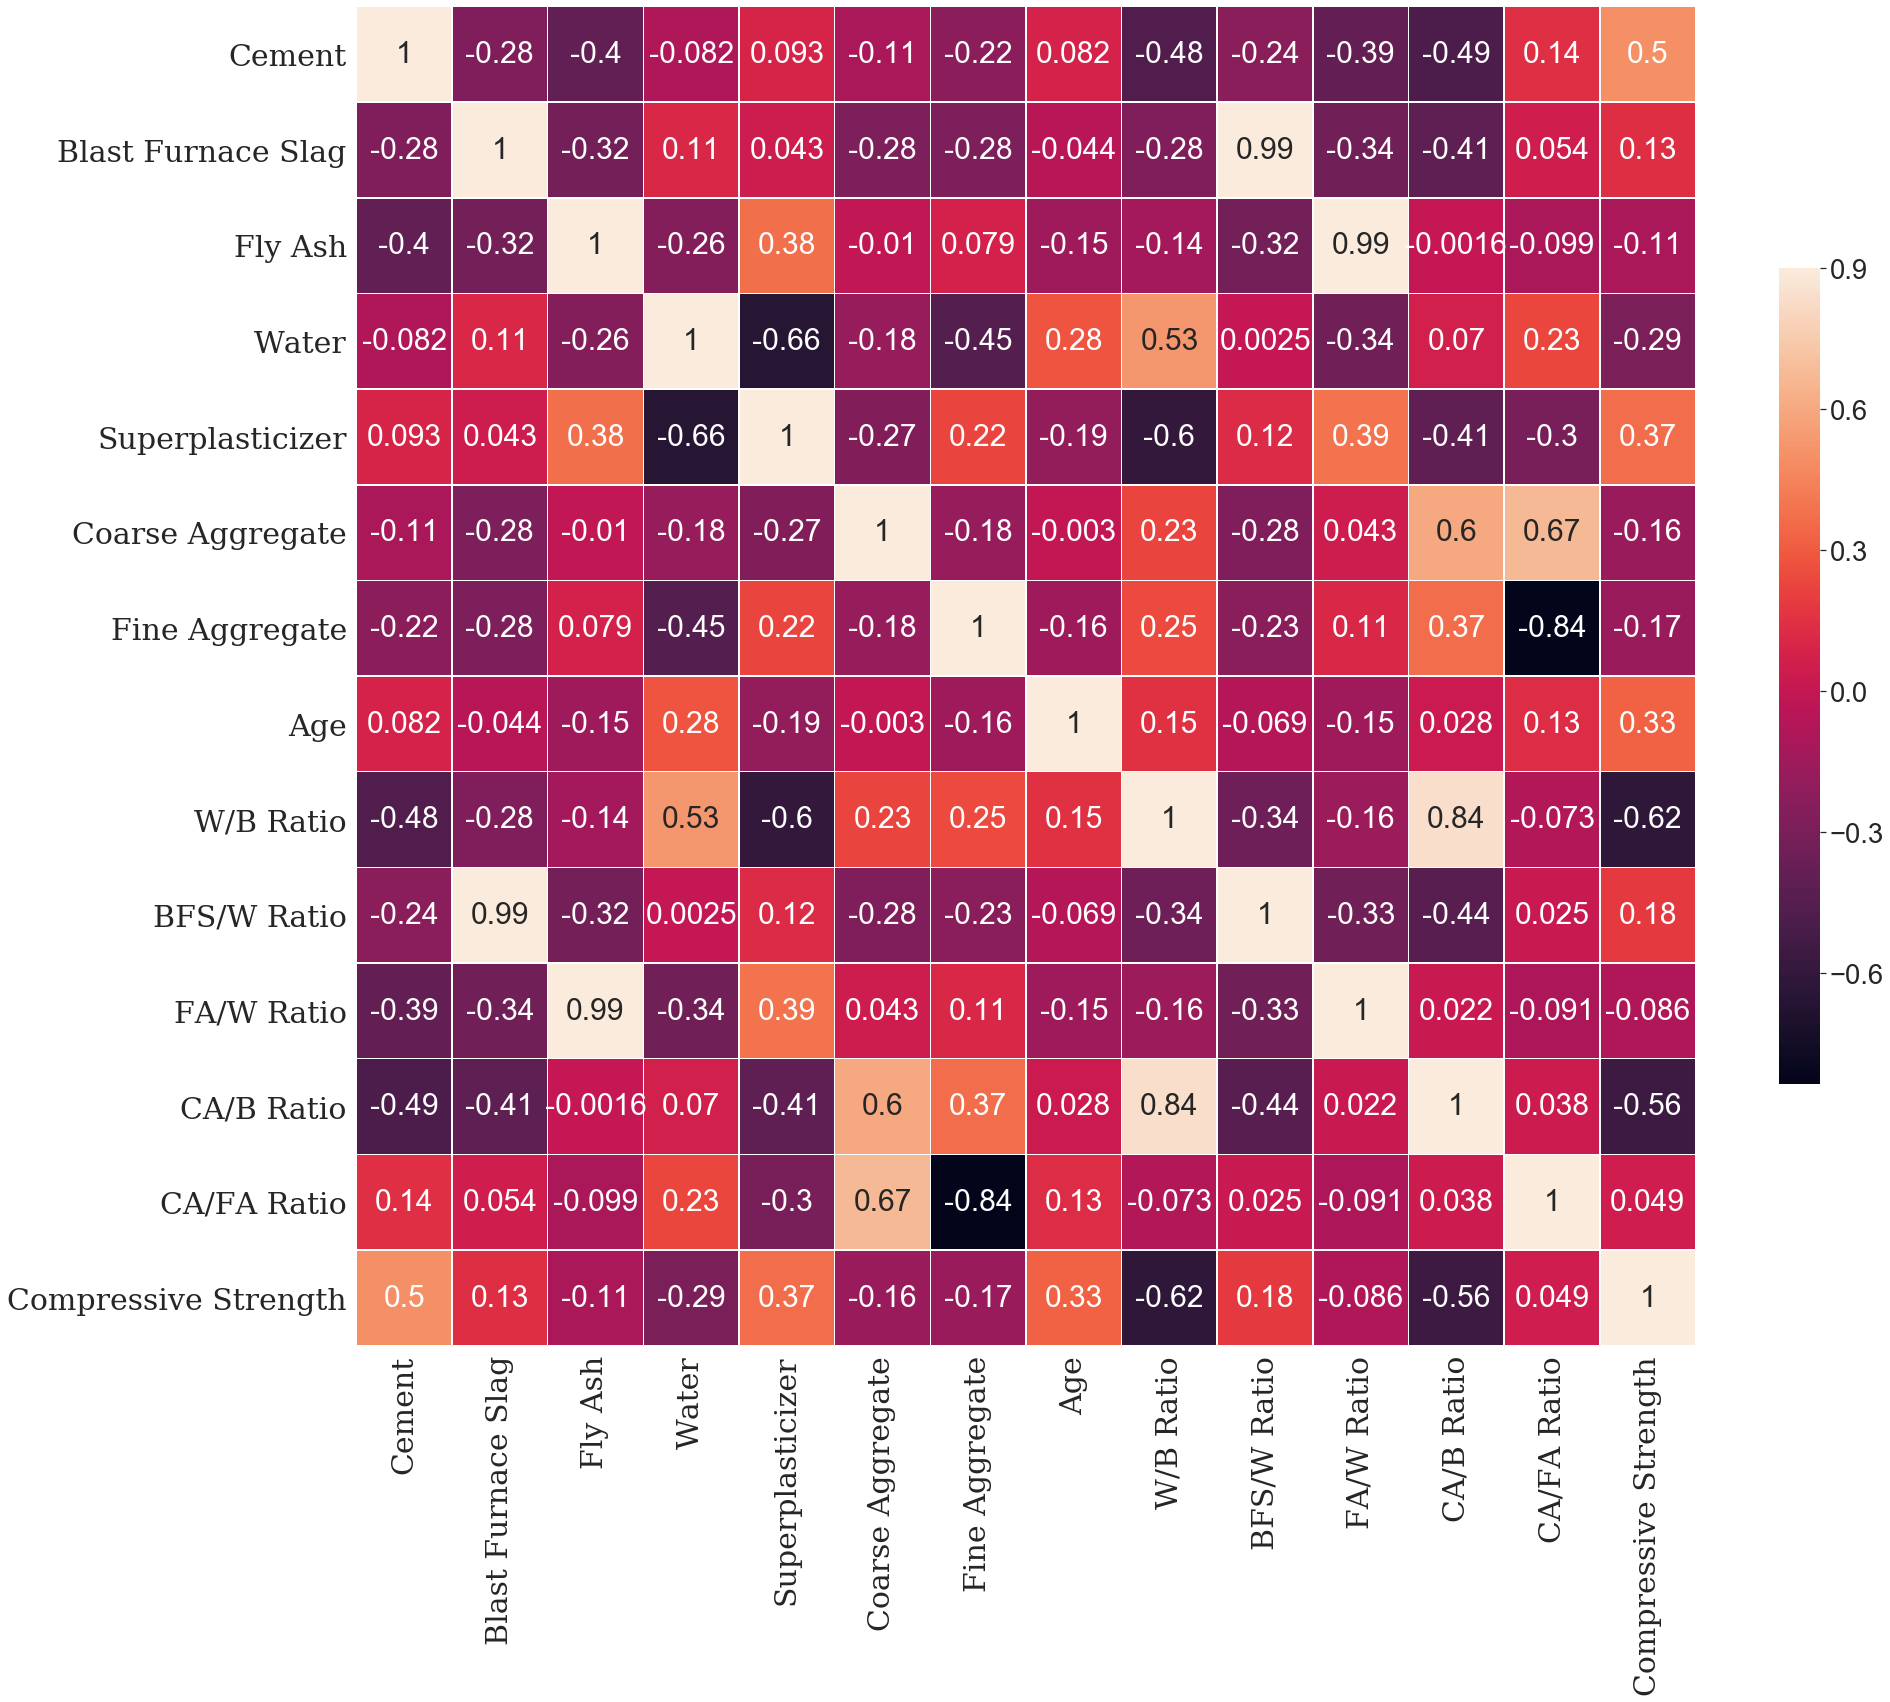

In [6]:
tmp = Data_DF['Compressive Strength']
Data_DF.drop(['Compressive Strength'], axis=1, inplace=True)
Data_DF['Compressive Strength'] = tmp

corr_mat = Data_DF.corr()
fig = plt.figure(figsize=(30,30),dpi=72)
sns.set(font_scale=2.5)
sns.heatmap(corr_mat, vmax=0.9, square=True, linewidths=.5, annot=True, annot_kws={"size": 30}, cbar_kws={"shrink": .5})
plt.xticks(fontsize=30, fontname='Serif', rotation=90)
plt.yticks(fontsize=30, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Correlation Heatmap.pdf')

In [7]:
#################################################################################################
# Create an array of features for model development
#################################################################################################
Feature_Names = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate',
                 'Age','W/B Ratio', 'BFS/W Ratio', 'FA/W Ratio', 'CA/B Ratio', 'CA/FA Ratio']

X = Data_DF[Feature_Names].to_numpy()
y = Data_DF['Compressive Strength'].to_numpy()

In [8]:
#################################################################################################
# Split data for training and testing
#################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=7)

In [9]:
model = XGBRegressor(objective ='reg:squarederror')

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='auto', verbosity=1)

In [10]:
#################################################################################################
# Make predictions on testing data and test model accuracy
#################################################################################################

Y_Test_Pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,Y_Test_Pred))
RSQ = r2_score(y_test,Y_Test_Pred)
MAPE = np.mean(np.abs((y_test - Y_Test_Pred) / y_test)) * 100
MAE = np.mean(np.abs(y_test - Y_Test_Pred))
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MAPE: %0.3f" % MAPE)
print("MAE: %0.3f" % MAE)
print("########################################")
print(" ")

############ Model Accuracy ############
RMSE: 3.986
R-squared: 0.944
MAPE: 11.511
MAE: 3.194
########################################
 


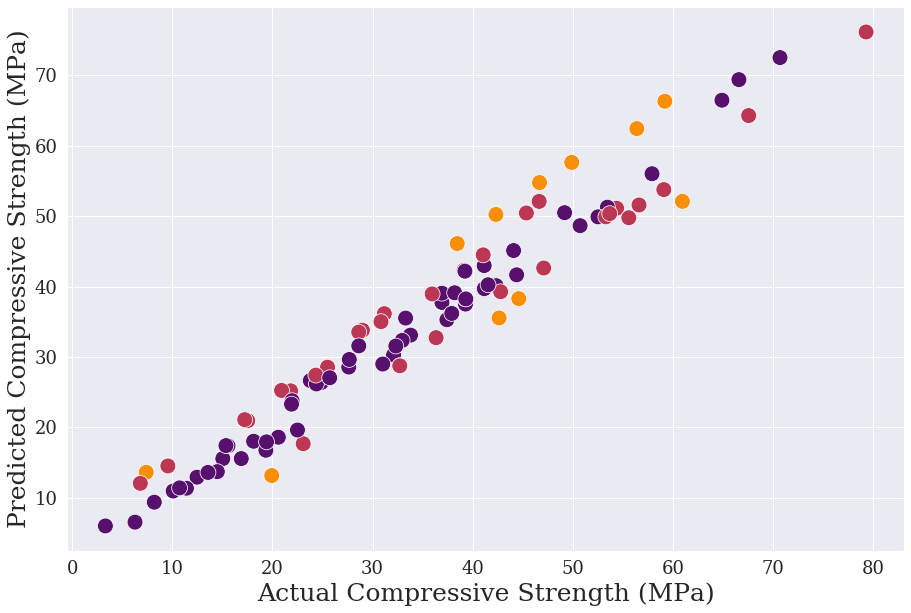

In [11]:
fig = plt.figure(figsize=(15,10),dpi=72)
#sns.set(font_scale=2.5)
my_hue = pd.cut(np.abs(y_test-Y_Test_Pred),[0,3,6,9],labels=['Min. residuals','Average residuals','Max. residuals'])
sns.scatterplot(y_test, Y_Test_Pred, color="darkgreen", s=250, hue = my_hue, palette='inferno', legend=False)
plt.xlabel("Actual Compressive Strength (MPa)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Compressive Strength (MPa)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Scatter_Plot_No_Tuning.pdf')

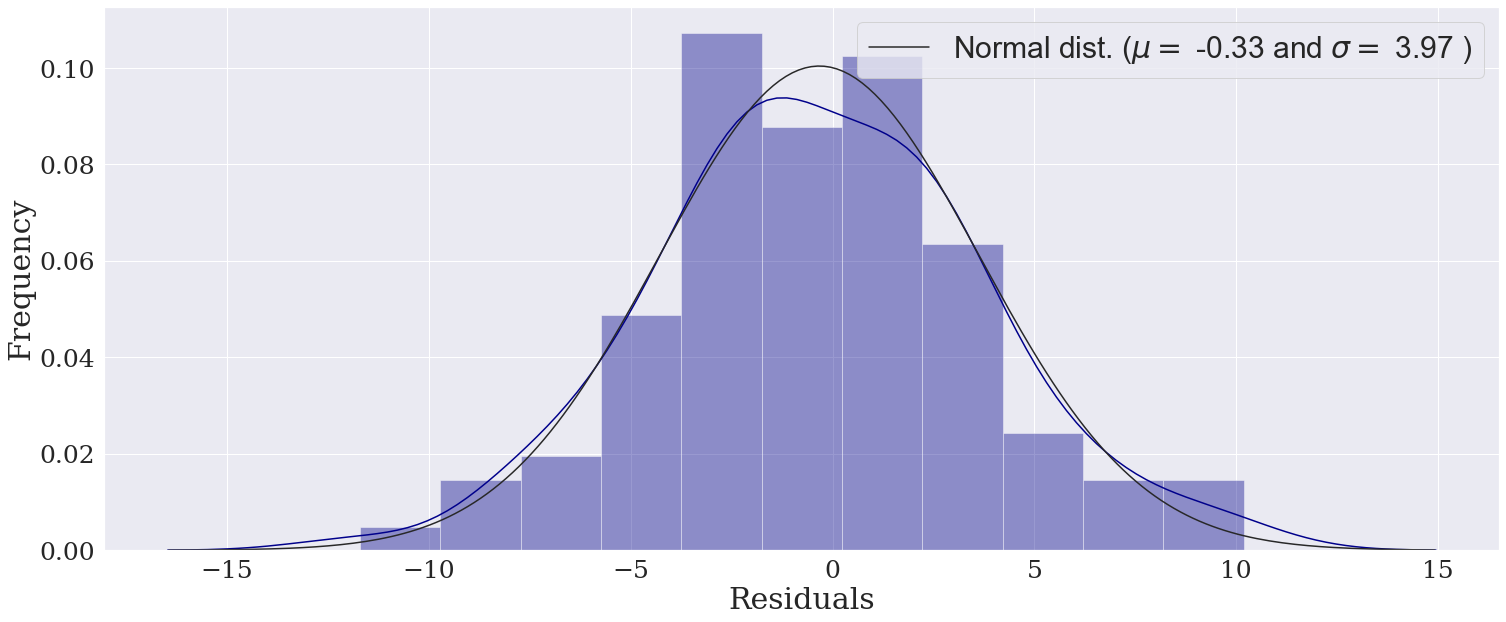

In [12]:
residuals = (y_test-Y_Test_Pred)
fig = plt.figure(figsize=(25,10),dpi=72)
sns.distplot(residuals, fit = norm, color='darkblue')
(mu, sigma) = norm.fit(residuals)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Residuals', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution No Tuning.pdf')